In [1]:
#-------#
#IMPORTS
#-------#
import os

%matplotlib inline
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms import Grayscale, Resize, ToTensor, Normalize, Compose, ConvertImageDtype
import matplotlib.pyplot as plt

from torch import nn
from torch import cuda
from torch import float32
import torch

import pandas as pd

### Paths for Training and Test data

In [2]:
path = ".\data\ChessFEN"
path_train = path + "\\train"
path_test = path + "\\test"

### Create CSV files that will be used in PyTorch Dataset. CSV containes image name and [FEN notation](https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation)

In [4]:
def create_csv_file(images_dir, file_name):
    #Creating data csv
    dict_list = []

    with os.scandir(images_dir) as scan:
        # Now iterate through os.DirEnry and show files or directories
        for file in scan:
            #i = index, file.name = name, label = tensor 13x8x8
            fen = file.name[:-5]
            new_row = {"file": file.name, "fen": fen}
            dict_list.append(new_row)

    #convert list to pandas data frame
    df = pd.DataFrame.from_records(dict_list)

    #save dafa frame into csv
    df.to_csv(file_name, index=False)

create_csv_file(path_train, "train.csv")
print("train.csv created")
create_csv_file(path_test, "test.csv")
print("test.csv created")

train.csv created
test.csv created


### Custom Dataset class to be used with Dataloader

In [3]:
class ChessDataset(Dataset):
    def __init__(self, images_path, csv_file, transform=None):
        self.images_path = images_path #dir of the images
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        
    def __getitem__(self, index):
        path = os.path.join(self.images_path, self.data.iloc[index, 0])
        X = read_image(path, mode=ImageReadMode.RGB)
        
        #encodes FEN string into tensor, to be used as lable for training
        def encoder(fen: str):
            tensor = torch.zeros([13, 8, 8], dtype=float32)
            column = 0
            row = 0
            pieces_dict = {"P": 1, "N": 2, "B": 3, "R": 4, "Q": 5, "K": 6, "p": 7, "n": 8, "b": 9, "r": 10, "q": 11, "k": 12}
            #fen consist of: number, piece, -.
            for i in fen:
                if i in pieces_dict.keys():
                    tensor[pieces_dict[i], row, column] = 1
                    column += 1
                elif i == "-":
                    column = 0
                    row += 1
                else:
                    tensor[0, row, column:column+int(i)] = 1
                    column += int(i)
            return tensor

        y = encoder(self.data.iloc[index, 1])
        
        if self.transform:
            X = self.transform(X) 
        return X, y #Image, tensor label dim:[13x8x8]

    def __len__(self):
        return len(self.data)

### Decoder function to convert tensors back into FEN notation

In [4]:
#decodes model output tensor into FEN string
#works on tensors coming from DataLoader aka [N, C, H, W], will not work with Dataset because of y dimensions
#fixed, need to work everywhere, in batch use: decoder(y_batch[0])
def decoder(tensor):
    piece_lst = ["P", "N", "B", "R", "Q", "K", "p", "n", "b", "r", "q", "k"]
    fen = ""
    tmp = 0
    for i in range(8):
        for j in range(8):
            #index of the class, 0=empty square, above 0 chess piece
            index = torch.argmax(tensor[:, i, j]) 
            if index > 0:
                if tmp > 0:
                    fen += str(tmp)
                fen += piece_lst[index-1]
                tmp = 0
                continue
            tmp += 1
        if tmp > 0:
            fen += str(tmp)
        tmp = 0
        fen += "-"
    return fen[:-1]

Some Train Data samples:


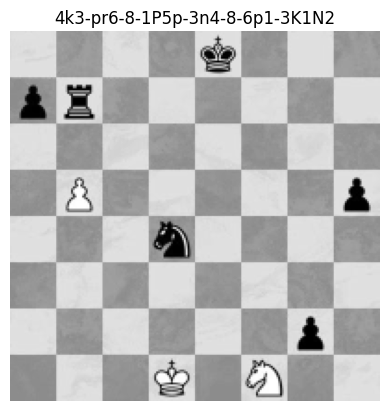

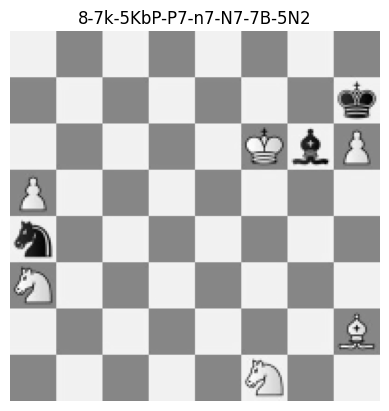

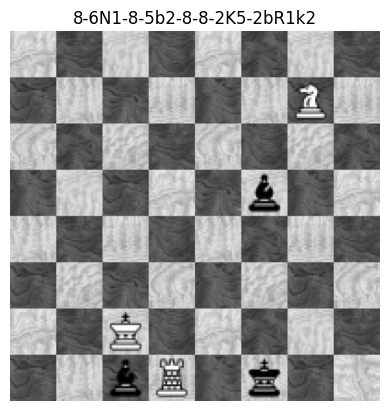

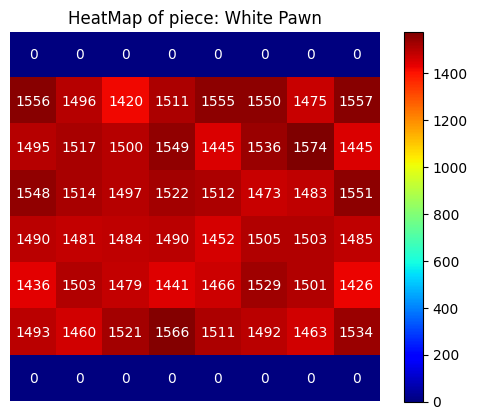

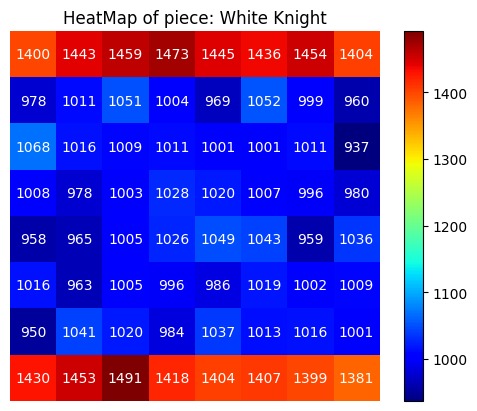

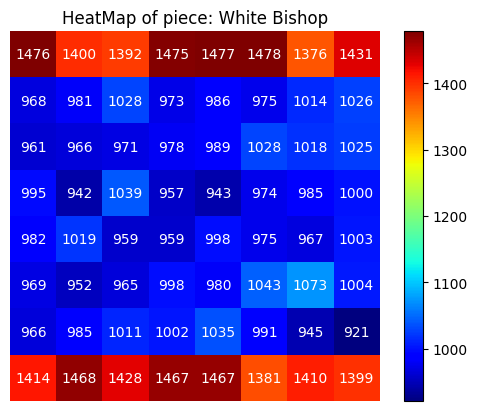

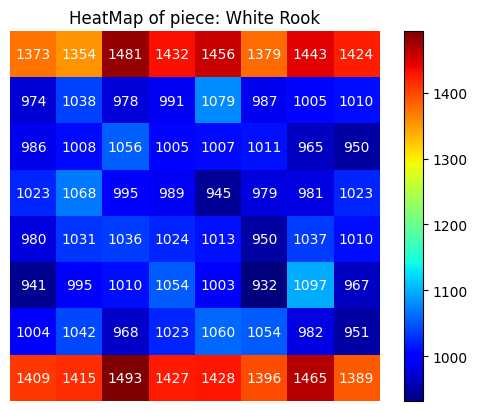

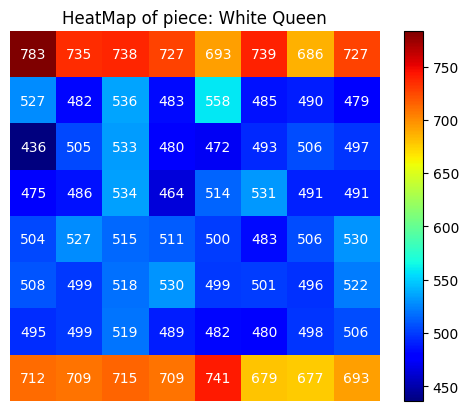

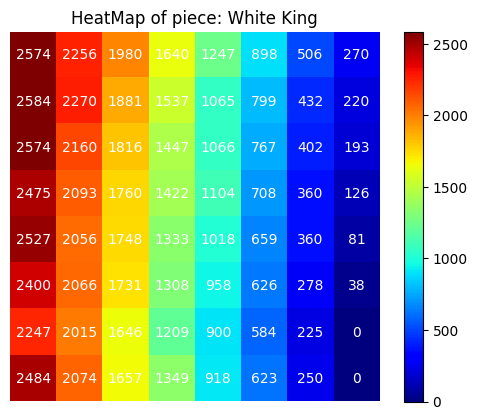

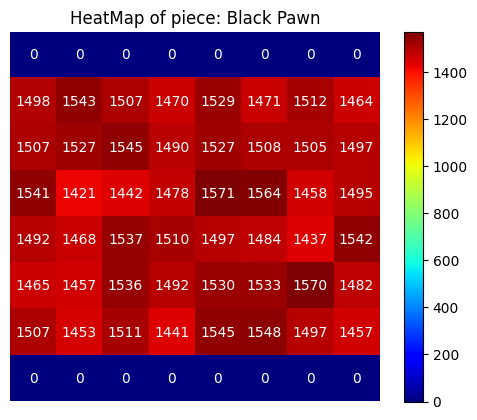

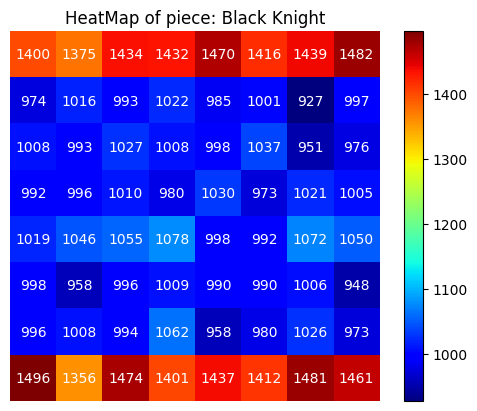

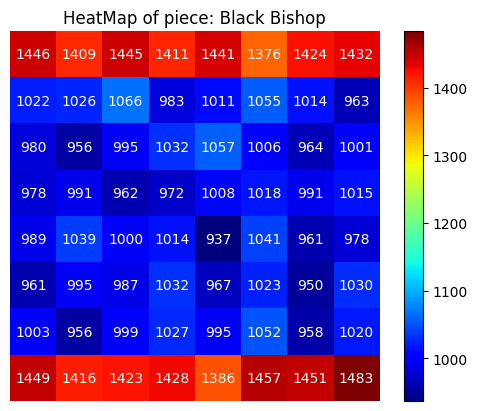

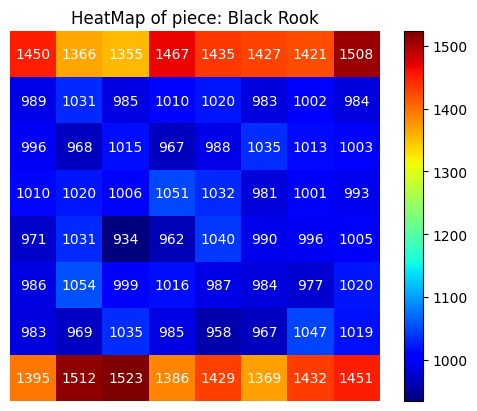

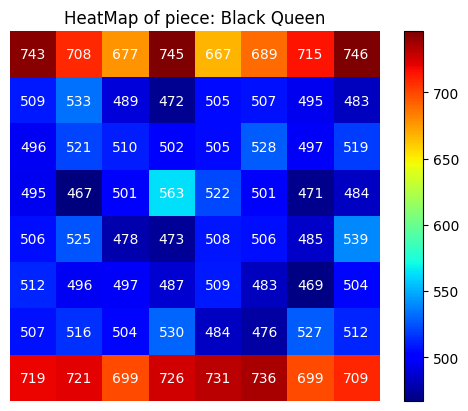

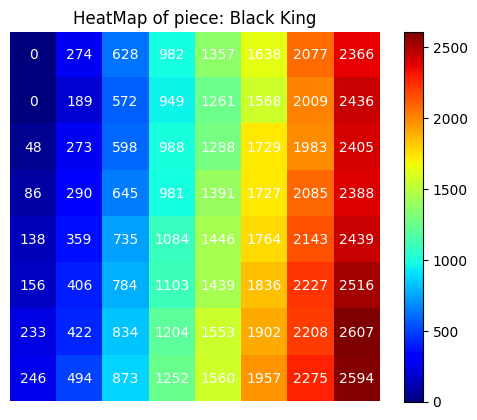

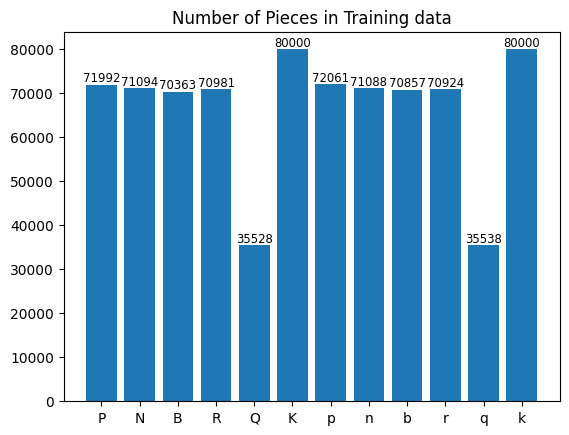

In [5]:
#----#
# EDA
#----#
def plot_image(img, labelTxt): 
    plt.title(labelTxt)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    
    plt.show()

augm = Compose([ConvertImageDtype(float32), Grayscale(), Resize((200, 200), antialias=False)])
eda_dataset = ChessDataset(path_train, "train.csv", transform=augm)
eda_loader = DataLoader(eda_dataset, shuffle=True)

print("Some Train Data samples:")
for ind, (X, y) in zip(range(3), eda_loader):
    plot_image(X.squeeze(), decoder(y[0]))
    

#Get stats about the pieces in the train set    
eda_df = pd.read_csv("train.csv")
pieces_hm_lst = [np.zeros(shape=(8, 8)) for i in range(12)]
pieces_count_dict = {"P": 0, "N": 0, "B": 0, "R": 0, "Q": 0, "K": 0, "p": 0, "n": 0, "b": 0, "r": 0, "q": 0, "k": 0}

#IF USED AS INDEX -1 PERFORMED
pieces_dict = {"P": 1, "N": 2, "B": 3, "R": 4, "Q": 5, "K": 6, "p": 7, "n": 8, "b": 9, "r": 10, "q": 11, "k": 12}

def fen_stats(fen):
    r, c = 0, 0
    for i in fen:
        if(i in pieces_count_dict.keys()):
            pieces_count_dict[i] += 1
            pieces_hm_lst[pieces_dict[i]-1][r, c] += 1
            c += 1
        elif(i == "-"): #end of row
            r += 1
            c = 0
        else: # i is number
            c += int(i)

#goes over all fen notations in train.csv and counts pieces and their position on the board
[fen_stats(i) for i in eda_df["fen"]]

#Check how different pieces distributed in the training data
#plots heatmap
def plot_piece_hm(matrix, piece):
    pieces_names = {"P": "White Pawn", "N": "White Knight", "B": "White Bishop", "R": "White Rook", "Q": "White Queen", "K": "White King", "p": "Black Pawn", "n": "Black Knight", "b": "Black Bishop", "r": "Black Rook", "q": "Black Queen", "k": "Black King"}
    plt.title(f"HeatMap of piece: {pieces_names[piece]}")
    plt.axis("off")
    plt.imshow(matrix, cmap="jet", interpolation="nearest")
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(j, i, int(matrix[i, j]), ha="center", va="center", color="w")
    plt.colorbar()
    plt.show()

#bar plot for pieces count stat
def plot_pieces_count(data):
    plt.title("Number of Pieces in Training data")
    bar = plt.bar(data.keys(), data.values())
    for i in bar:
        height = i.get_height()
        plt.text((i.get_x()+i.get_width()/2), height, height, ha="center", va="bottom", size="small")
    plt.show()
    
[plot_piece_hm(pieces_hm_lst[pieces_dict[k]-1], k) for k in pieces_dict.keys()]
plot_pieces_count(pieces_count_dict)

In [6]:
#Get cpu or gpu device for training.
device = "cuda" if cuda.is_available() else "cpu"
print("Using {} device".format(device))

# Define model
class FENNetwork(nn.Module):
    def __init__(self):
        super(FENNetwork, self).__init__()
        
        self.conv_sequence1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(5, 5), stride=2, bias=False),
            nn.BatchNorm2d(num_features=2),
            nn.ReLU(),
        
            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(3, 3), stride=1, bias=False),
            nn.BatchNorm2d(num_features=4),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), stride=1, bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), stride=3, padding=1, bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(4, 4), stride=4, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=13, kernel_size=(1, 1), stride=1, bias=False),
            nn.ReLU()
        )

    def forward(self, x):
        logits = self.conv_sequence1(x)
        return logits

model = FENNetwork().to(device)
print(model)
#input: 200x200 (1x200x200), output: 8x8 (13x8x8)

Using cuda device
FENNetwork(
  (conv_sequence1): Sequential(
    (0): Conv2d(1, 2, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(8, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(16, 32, kernel_size=(4, 4), stride=(4, 4), bias=False)
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(32, 13, kernel_size=(1, 1), st

### Model layers with number of parameters and total number of model parameters

In [7]:
total = 0
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Params : {param.numel()} \n")
    total += param.numel()
print(f"Total: {total}")

Layer: conv_sequence1.0.weight | Size: torch.Size([2, 1, 5, 5]) | Params : 50 

Layer: conv_sequence1.1.weight | Size: torch.Size([2]) | Params : 2 

Layer: conv_sequence1.1.bias | Size: torch.Size([2]) | Params : 2 

Layer: conv_sequence1.3.weight | Size: torch.Size([4, 2, 3, 3]) | Params : 72 

Layer: conv_sequence1.4.weight | Size: torch.Size([4]) | Params : 4 

Layer: conv_sequence1.4.bias | Size: torch.Size([4]) | Params : 4 

Layer: conv_sequence1.6.weight | Size: torch.Size([8, 4, 3, 3]) | Params : 288 

Layer: conv_sequence1.7.weight | Size: torch.Size([8]) | Params : 8 

Layer: conv_sequence1.7.bias | Size: torch.Size([8]) | Params : 8 

Layer: conv_sequence1.9.weight | Size: torch.Size([16, 8, 3, 3]) | Params : 1152 

Layer: conv_sequence1.10.weight | Size: torch.Size([16]) | Params : 16 

Layer: conv_sequence1.10.bias | Size: torch.Size([16]) | Params : 16 

Layer: conv_sequence1.12.weight | Size: torch.Size([32, 16, 4, 4]) | Params : 8192 

Layer: conv_sequence1.13.weight |

### Initialize model weights

In [8]:
def weight_init_func(m):
    classname = m.__class__.__name__
    if(classname.find('Conv') != -1):
        torch.nn.init.xavier_uniform_(m.weight)
        print(f"Layer. {m.__class__.__name__} Initialized")

model.apply(weight_init_func)

Layer. Conv2d Initialized
Layer. Conv2d Initialized
Layer. Conv2d Initialized
Layer. Conv2d Initialized
Layer. Conv2d Initialized
Layer. Conv2d Initialized


FENNetwork(
  (conv_sequence1): Sequential(
    (0): Conv2d(1, 2, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(8, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(16, 32, kernel_size=(4, 4), stride=(4, 4), bias=False)
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(32, 13, kernel_size=(1, 1), stride=(1, 1), bias=

In [9]:
#-------------------------#
#setting variables for training
#-------------------------#
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

#-------------------------------#
#track Average Loss and Accuracy
#-------------------------------#
hist_train_loss = []
hist_test_loss = []
hist_train_accuracy = []
hist_test_accuracy = []

### Main train/test loop

In [10]:
#-------------#
#-TRAINIG LOOP
#-------------#
#----------------#
#making datasets
#---------------#
trans = Compose([ConvertImageDtype(float32), Grayscale(), Resize((200, 200), antialias=False)])
train_dataset = ChessDataset(path_train, "train.csv", transform=trans)
test_dataset = ChessDataset(path_test, "test.csv", transform=trans)

#-------------------------------------#
#making datloaders out of the datasets
#-------------------------------------#
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

#------------------------------------#
#single train and test loop functions
#------------------------------------#
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    tmp_loss, tmp_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        tmp_loss += loss.item()
        pred_fen = (decoder(i) for i in pred)
        y_fen = (decoder(i) for i in y)
        tmp_acc += len(tuple(set(pred_fen).intersection(y_fen)))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #save avg loss and accuracy
    hist_train_loss.append(tmp_loss/size)
    hist_train_accuracy.append(100*tmp_acc/size)
            
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            #decoding to get fen and see if prediction is correct
            pred_fen = (decoder(i) for i in pred)
            y_fen = (decoder(i) for i in y)
            correct += len(tuple(set(pred_fen).intersection(y_fen)))
    
    #save avg loss and accuracy
    hist_test_loss.append(test_loss/size)
    hist_test_accuracy.append(100*correct/size)

#-----------#
# epoch loop
#----------#
epochs = 18
for t in range(epochs):
    print(f"Epoch {t+1} start.")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model)
    print(f"Train: Loss: {hist_train_loss[-1]}, Accuracy: {hist_train_accuracy[-1]}")
    print(f"Test: Loss: {hist_test_loss[-1]}, Accuracy: {hist_test_accuracy[-1]}")
print("Done!")

Epoch 1 start.
Train: Loss: 0.004151274513732642, Accuracy: 6.30375
Test: Loss: 0.0010253030467778444, Accuracy: 31.62
Epoch 2 start.
Train: Loss: 0.00045839339164085687, Accuracy: 50.485
Test: Loss: 0.0002705362350679934, Accuracy: 61.585
Epoch 3 start.
Train: Loss: 0.0001923556222463958, Accuracy: 70.75375
Test: Loss: 0.00015101429829373955, Accuracy: 75.285
Epoch 4 start.
Train: Loss: 0.00011126702761393972, Accuracy: 81.2175
Test: Loss: 8.701220008078962e-05, Accuracy: 84.895
Epoch 5 start.
Train: Loss: 7.049642985220999e-05, Accuracy: 87.1725
Test: Loss: 6.138199907727539e-05, Accuracy: 88.31
Epoch 6 start.
Train: Loss: 4.629597835591994e-05, Accuracy: 91.4575
Test: Loss: 4.0041861345525834e-05, Accuracy: 92.62
Epoch 7 start.
Train: Loss: 3.208972260472365e-05, Accuracy: 94.015
Test: Loss: 3.2617540413048116e-05, Accuracy: 93.58
Epoch 8 start.
Train: Loss: 2.3948438065417578e-05, Accuracy: 95.54875
Test: Loss: 2.733443985343911e-05, Accuracy: 94.075
Epoch 9 start.
Train: Loss: 1.8

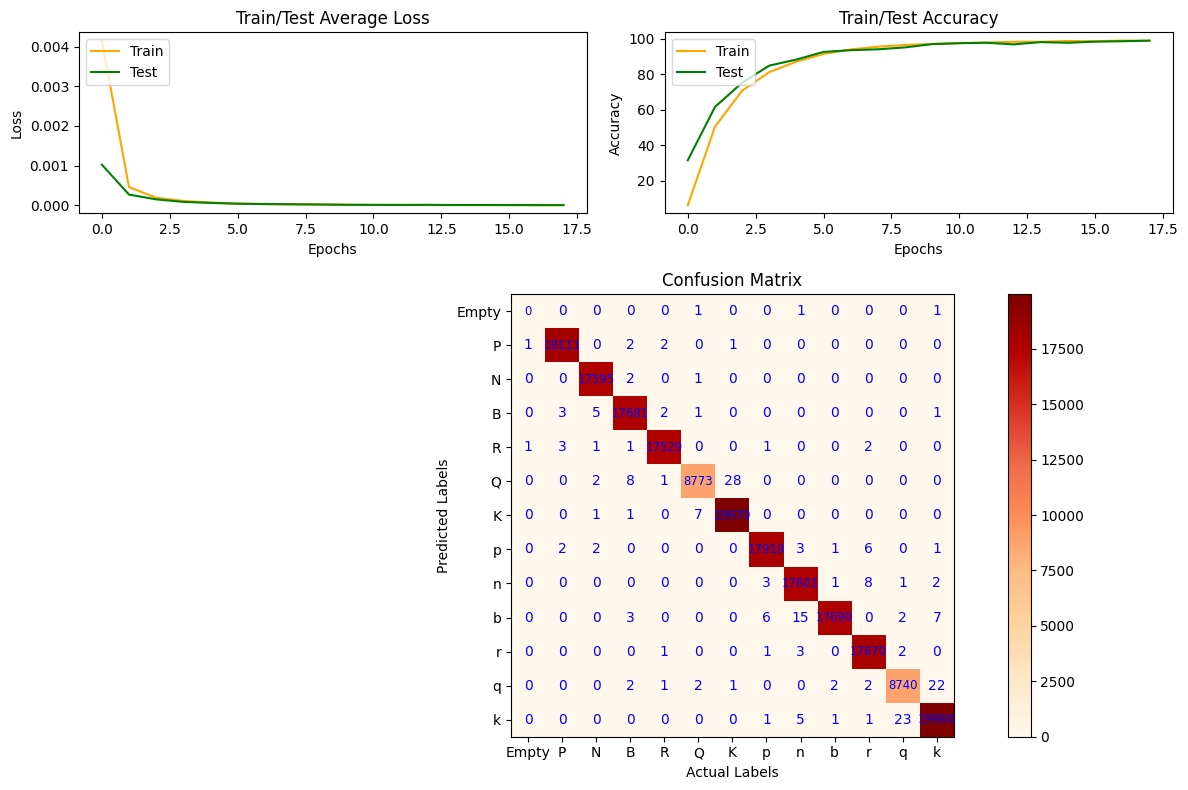

In [12]:
#Model Evaluation, See results
eval_dataset = ChessDataset(path_test, "test.csv", transform=augm)
eval_loader = DataLoader(eval_dataset, batch_size=256, shuffle=True)

#go over tensors and compare/fill confusion matrix per batch
#matrices rows-predicted class, matrices columns-labeled/actual class.
conf_mat = np.zeros(shape=(13, 13), dtype=int)

#Create Confusion Matrix
model.eval()
with torch.no_grad():
    for X, y in eval_loader:
        X = X.to(device)
        y = y.to(device)
        predictions = model(X) #shape (batch, 13, 8, 8)
        pred_classes = predictions.argmax(axis=1) #shape (batch, 8, 8). with the 8x8 containing class(pieces as index)
        label_classes = y.argmax(axis=1)          #shape (batch, 8, 8) 
        for label, pred in zip(label_classes, pred_classes): #go over batch
            for element_y, element_p in zip(torch.flatten(label), torch.flatten(pred)):
                conf_mat[element_p, element_y] += 1
#Currectly predicted empty squares are way bigger than other pieces so is saved and zeroed to see better result on the confusion matrix of pieces
save_empty_currect_pred = conf_mat[0, 0]
conf_mat[0, 0] = 0

#Plot
gridsize = (3, 2)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (1, 0), colspan=2, rowspan=2) #Confusion matrix plot
ax2 = plt.subplot2grid(gridsize, (0, 0)) #Avg Loss plot
ax3 = plt.subplot2grid(gridsize, (0, 1)) #Accuracy plot
#ax1
im = ax1.imshow(conf_mat, cmap="OrRd", interpolation="nearest")
ax1.set_xlabel("Actual Labels")
ax1.set_ylabel("Predicted Labels")
ax1.set_title("Confusion Matrix")
ax1.set_xticks(range(13))
ax1.set_xticklabels(["Empty", "P", "N", "B", "R", "Q", "K", "p", "n", "b", "r", "q", "k"])
ax1.set_yticks(range(13))
ax1.set_yticklabels(["Empty", "P", "N", "B", "R", "Q", "K", "p", "n", "b", "r", "q", "k"])
fig.colorbar(im)
for i in range(0, conf_mat.shape[0]):
    for j in range(0, conf_mat.shape[1]):
        if(i == j): #diagonal of correct prediction has bigger numbers so making font smaller
            ax1.text(j, i, conf_mat[i, j], ha="center", va="center", size="small", color="b")
        else:
            ax1.text(j, i, conf_mat[i, j], ha="center", va="center", size="medium", color="b")
#ax2
ax2.plot(hist_train_loss, color="orange")
ax2.plot(hist_test_loss, color="green")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Train/Test Average Loss")
ax2.legend(("Train", "Test"), loc="upper left")
#ax3
ax3.plot(hist_train_accuracy, color="orange")
ax3.plot(hist_test_accuracy, color="green")
ax3.set_xlabel("Epochs")
ax3.set_ylabel("Accuracy")
ax3.set_title("Train/Test Accuracy")
ax3.legend(("Train", "Test"), loc="upper left")

fig.tight_layout()